# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import pickle
from tqdm import tqdm

# Custom
from config import model_config
from regression import reg

# Stats
from sklearn.feature_selection import(
	RFECV, SequentialFeatureSelector
)
from sklearn.linear_model import (
	LinearRegression, LogisticRegression,
)
from sklearn.metrics import (
	confusion_matrix, classification_report, f1_score,
)
from sklearn.model_selection import (
	train_test_split, RandomizedSearchCV, GridSearchCV, 
	cross_val_score,
)
from sklearn.pipeline import (
	Pipeline
)
from sklearn.preprocessing import (
	LabelEncoder, OneHotEncoder, StandardScaler,
	RobustScaler, QuantileTransformer, FunctionTransformer
)
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Global vars
SEED = 123
TEST_SIZE = 0.25
HEATMAP_COLORS = sns.diverging_palette(h_neg=250, h_pos=359, as_cmap=True)
SIGNIFICANCE_CUTOFF = 0.05

# Import/Preprocess Data

In [2]:
with open(Path('../data/prediction_data.pkl'), 'rb') as f:
	data = pickle.load(f)
	
X = data.get('X')
y = data.get('y')
body_features = data.get('body_features')
cardio_features = data.get('cardio_features')

print(X.shape)

X.head()

(95, 17)


,density_visceral_fat,mass_visceral_fat,density_intermuscular_fat,density_muscle,density_bone,bmi,emphysema_volume_950hu,extrapulmonary_vein_volume,artery_vein_ratio,bv10,pb_larger_10,pv_a,heart_volume,airway_ratio,ild_volume,age,gender_cl_Male
PE1_0,-0.664818,-1.165809,-0.147435,-0.256701,-1.777867,0.203818,-0.106865,2.137818,-1.150427,0.494738,1.912364,1.263457,1.782875,-0.309816,-0.721954,-0.014636,1.0
PE12_0,-0.041982,1.031574,-0.799236,-0.453552,-0.626438,-0.164653,-0.476252,0.372377,0.021395,0.979777,0.403948,1.315332,0.195270,0.391257,1.080036,-0.282771,1.0
PE12_1,0.105724,1.374941,1.101050,0.780404,-0.157632,-0.164653,-0.743299,-0.139077,-0.105302,-1.715825,0.621574,-0.172731,0.608057,1.239597,1.392983,-0.282771,1.0
PE14_0,1.297917,-0.722682,1.549786,0.317693,-0.270970,-0.478136,1.156899,0.394634,-0.157870,0.451135,0.093329,0.009487,0.217828,-0.568843,-1.825349,-1.199497,0.0
PE15_0,1.177249,-1.684023,1.401407,1.052018,0.819345,-1.881309,-0.465319,-0.547764,0.329446,0.485155,-0.773213,0.272429,-1.091411,0.044701,-0.201688,-2.011256,0.0


In [3]:
y.head()

,total_clot_burden,centralartery,apical_rs1,posterior_rs2,anterior_rs3,lateral_rs4,medial_rs5,superior_rs6,medial_basal_rs7,anterior_basal_rs8,...,posterior_basal_rs10,apical_ls1,posterior_ls2,anterior_ls3,superior_ls4,inferior_ls5,superior_ls6,anteromedial_basal_ls7_8,lateral_basal_ls9,posterior_basal_ls10
PE1_0,1.229949,1.281445,1.806963,2.116559,2.230291,1.966303,2.395154,2.299967,-0.357074,1.033297,...,0.969729,-0.512367,-0.449242,0.898833,2.935201,-0.402679,-0.598302,0.102318,1.285175,1.109191
PE12_0,-0.256730,-0.839974,-0.099962,-0.513168,-0.478392,1.605058,1.245726,-0.492346,-0.382820,1.713990,...,-0.570978,-0.512367,-0.449242,-0.548919,-0.463017,-0.402679,-0.598302,-0.605156,-0.588163,-0.678984
PE12_1,-0.094990,0.156289,-0.597556,-0.513168,-0.519294,0.416968,-0.496983,-0.626172,-0.382820,-0.624794,...,-0.570978,-0.512367,-0.449242,-0.548919,-0.463017,-0.402679,-0.598302,-0.605156,-0.588163,-0.678984
PE14_0,-0.199894,-0.143623,-0.597556,-0.513168,-0.519294,0.288128,-0.496983,-0.626172,-0.382820,1.205505,...,-0.570978,-0.512367,-0.449242,-0.548919,-0.463017,0.095485,-0.598302,-0.605156,0.275131,-0.678984
PE15_0,-0.924821,-0.999449,-0.597556,-0.513168,-0.519294,-0.669858,-0.496983,-0.626172,-0.382820,-0.624794,...,-0.570978,-0.512367,-0.449242,-0.548919,-0.463017,-0.402679,-0.598302,-0.605156,-0.588163,0.062691


In [4]:
print(body_features)
print(cardio_features)

['density_visceral_fat', 'mass_visceral_fat', 'density_intermuscular_fat', 'density_muscle', 'density_bone', 'bmi']
['emphysema_volume_950hu', 'extrapulmonary_vein_volume', 'artery_vein_ratio', 'bv10', 'pb_larger_10', 'pv_a', 'heart_volume', 'airway_ratio', 'ild_volume']


# OLS Regression Functions

We loop through each of the numerical target variables (the various clot burden measures for different locations, as well as the total clot burden), and perform a simple single-variable OLS regression. Shown below are the statistically significant results at the 95% confidence level.

In [5]:
def combine_feat_and_controls(features=None, controls=None):
	if isinstance(features, str):
		feat_set = set([features])
	elif isinstance(features, list):
		feat_set = set(features)
	if controls is None:
		control_set = set()
	else:
		control_set = set(controls)
	all_feat = list(feat_set.union(control_set))
	return all_feat

In [6]:
def ols_regression(Xdata, Ydata, targets, features=None, controls=None):
	if controls is not None:
		control_name = '_'.join(controls)
	else:
		control_name = 'None'
	all_target_results = list()
	for target in targets:
		y_temp = Ydata[[target]].copy()
		single_model_results = list()
		for feat in features:
			temp_features = combine_feat_and_controls(feat, controls)
			X_temp = sm.add_constant(Xdata.loc[:, temp_features].copy())
			regression_results = sm.OLS(y_temp, X_temp).fit(cov_type='HC3')
			results_df = pd.DataFrame({
				'coef': regression_results.params,
				'pvalue': regression_results.pvalues,
				'nobs': regression_results.nobs,
				'r2_adj': regression_results.rsquared_adj,
			}).stack()
			results_df.index = [(item[0].replace(feat, 'variable'), item[1]) for item in results_df.index.tolist()]
			results_df.name = (target, feat, control_name)
			single_model_results.append(results_df)
		all_model_results = pd.concat(single_model_results, axis=1).transpose()
		all_model_results.columns = ['_'.join(item) for item in all_model_results.columns.to_list()]
		all_model_results.index.names = ['y_var', 'x_var', 'controls']
		all_target_results.append(all_model_results)
	all_target_results_df = pd.concat(all_target_results, axis=0)
	all_target_results_df = all_target_results_df.sort_index()
	return all_target_results_df

In [7]:
def ols_identify_significant(ols_results, signif_cutoff, out_path, display=False):
	signif_cb_bodycomp = (
		ols_results.loc[ols_results.variable_pvalue <= signif_cutoff, :]
		.sort_values(by='variable_pvalue')
	)
	signif_cb_bodycomp.to_csv(out_path)
	if display:
		return (
			signif_cb_bodycomp
			.style
				.background_gradient(subset='variable_pvalue')
				.format("{:.3f}")
		)
	else:
		return None

In [8]:
def ols_heatmap(ols, out_path, subtitle, figsize=(9, 7)):
	ols = ols.copy()
	ols.index = pd.MultiIndex.from_tuples(zip(ols.index.get_level_values(0), ols.index.get_level_values(1)))
	fig, axs = plt.subplots(figsize=figsize)
	sns.heatmap(
		ols.loc[ols['variable_pvalue']<=SIGNIFICANCE_CUTOFF].variable_coef.unstack(level=1),
		annot=ols.loc[ols['variable_pvalue']<=SIGNIFICANCE_CUTOFF].variable_pvalue.unstack(level=1), 
		annot_kws={"fontsize":8},
		fmt = '.3f',
		center=0.0,
		cmap=HEATMAP_COLORS,
	)

	for t in axs.texts: 
		t.set_text('p=' + t.get_text())

	axs.set_ylabel('Clot Burden Measure')
	axs.set_xlabel('Body Composition Measure')
	plt.suptitle('Coefficient Heatmap: red=positive coef, blue=negative coef', fontsize=16)
	plt.title(subtitle, fontsize=14)
	plt.tight_layout()
	plt.savefig(out_path)
	plt.show()

In [9]:
def r2_adjusted(r2, n, k):
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

In [10]:
def feature_selection_regressions(feature_selection_results, selection_method, controls=None):
    regressions = pd.DataFrame()
    
    if controls is None:
        controls_str = 'None'
    else:
        controls_str = '_'.join(controls)
    
    for target in model_config.num_targets:
        x_vars = combine_feat_and_controls(list(feature_selection_results[target]), controls)
        X_temp = sm.add_constant(X.loc[:, x_vars])
        y_temp = y.loc[:, target]
        fitted_model = sm.OLS(y_temp, X_temp).fit(cov_type='HC3')
        
        regression_output = pd.DataFrame({
            'coef': fitted_model.params,
            'pval': fitted_model.pvalues,
            'nobs': fitted_model.nobs,
        })
        
        regression_output['signif'] = regression_output.pval.apply(reg.add_significance)
        regression_output.index = pd.MultiIndex.from_tuples(
            list(zip(
                [selection_method for _ in range(regression_output.shape[0])],
                [target for _ in range(regression_output.shape[0])], 
                regression_output.index,
                [controls_str for _ in range(regression_output.shape[0])],
                )),
            names=('feature_selection_method', 'y', 'X', 'controls')
        )
        regressions = pd.concat((regressions, regression_output), axis=0)
    return regressions

In [11]:
ols_nocontrols = ols_regression(
	Xdata=X, Ydata=y, 
	targets=y.columns,
	features=body_features,
	controls=None
)
ols_nocontrols

const_coef  \
y_var              x_var                     controls                 
anterior_basal_rs8 bmi                       None     -7.979728e-17   
                   density_bone              None     -7.979728e-17   
                   density_intermuscular_fat None     -7.979728e-17   
                   density_muscle            None     -7.979728e-17   
                   density_visceral_fat      None     -7.979728e-17   
...                                                             ...   
total_clot_burden  density_bone              None     -1.110223e-16   
                   density_intermuscular_fat None     -1.110223e-16   
                   density_muscle            None     -1.110223e-16   
                   density_visceral_fat      None     -1.110223e-16   
                   mass_visceral_fat         None     -1.110223e-16   

                                                       const_pvalue  \
y_var              x_var                     controls                 
anterior_basal_rs8 bmi                       None               1.0   
                   density_bone              None               1.0   
                   density_intermuscular_fat None               1.0   
                   density_muscle            None               1.0   
                   density_visceral_fat      None               1.0   
...                                                             ...   
total_clot_burden  density_bone              None               1.0   
                   density_intermuscular_fat None               1.0   
                   density_muscle            None               1.0   
                   density_visceral_fat      None               1.0   
                   mass_visceral_fat         None               1.0   

                                                       const_nobs  \
y_var              x_var                     controls               
anterior_basal_rs8 bmi                       None            95.0   
                   density_bone              None            95.0   
                   density_intermuscular_fat None            95.0   
                   density_muscle            None            95.0   
                   density_visceral_fat      None            95.0   
...                                                           ...   
total_clot_burden  density_bone              None            95.0   
                   density_intermuscular_fat None            95.0   
                   density_muscle            None            95.0   
                   density_visceral_fat      None            95.0   
                   mass_visceral_fat         None            95.0   

                                                       const_r2_adj  \
y_var              x_var                     controls                 
anterior_basal_rs8 bmi                       None         -0.006385   
                   density_bone              None         -0.006625   
                   density_intermuscular_fat None          0.010915   
                   density_muscle            None         -0.008235   
                   density_visceral_fat      None         -0.005270   
...                                                             ...   
total_clot_burden  density_bone              None          0.025428   
                   density_intermuscular_fat None          0.019381   
                   density_muscle            None          0.025820   
                   density_visceral_fat      None          0.012180   
                   mass_visceral_fat         None         -0.010736   

                                                       variable_coef  \
y_var              x_var                     controls                  
anterior_basal_rs8 bmi                       None          -0.065737   
                   density_bone              None           0.063908   
                   density_intermuscular_fat None          -0.146416   
                   density_

# Body Composition

## Univariate Regressions

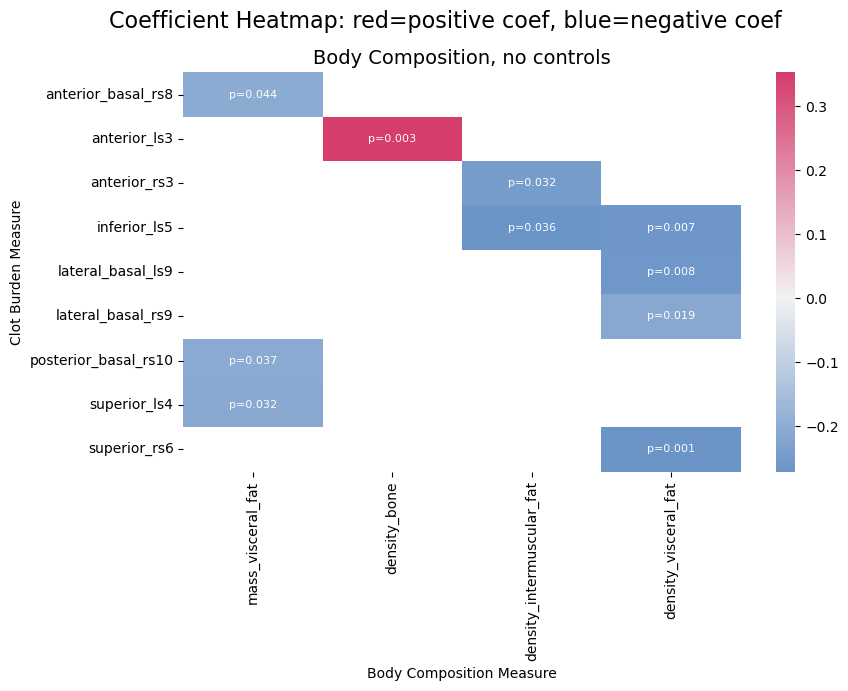

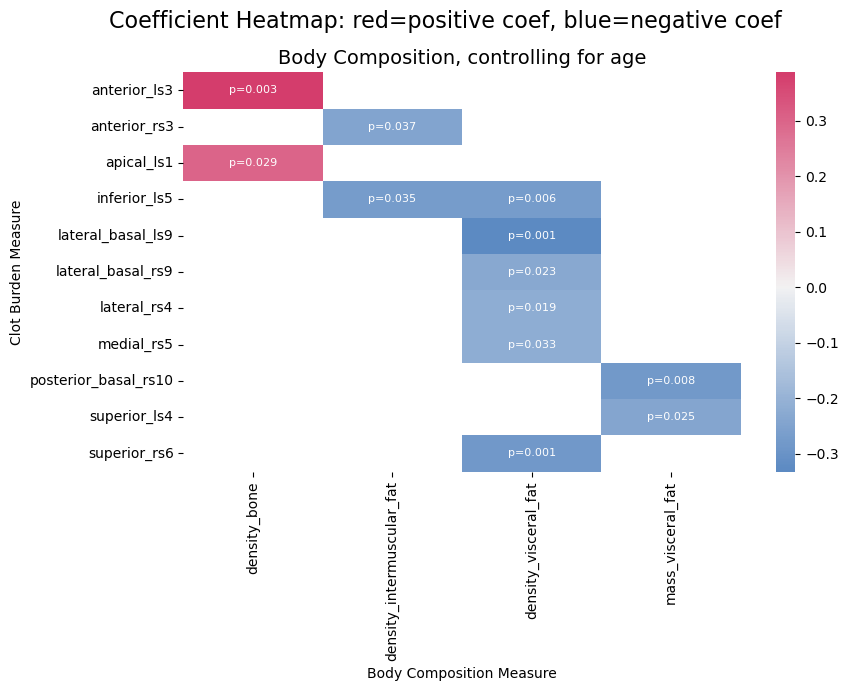

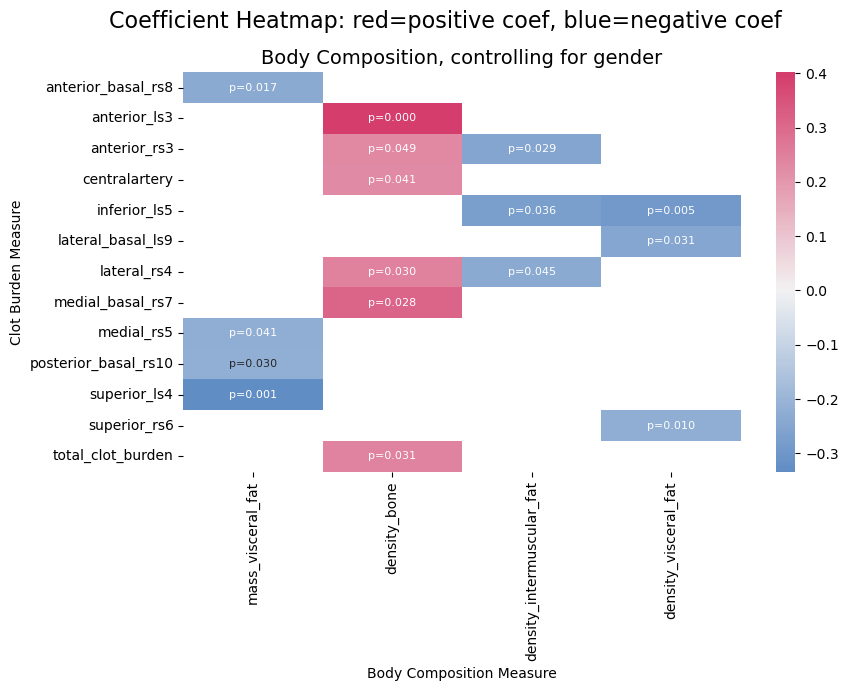

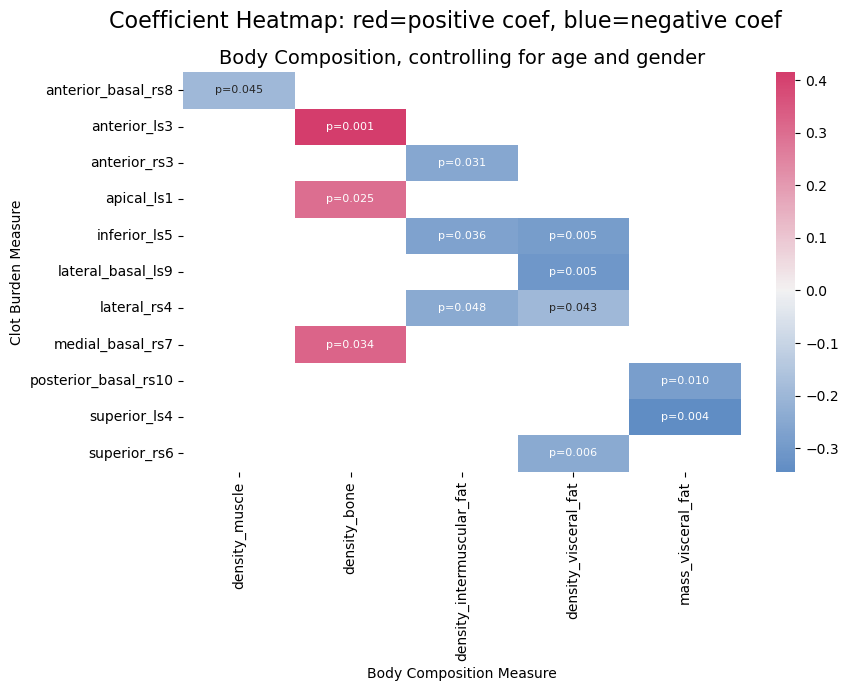

In [12]:
body_regressions_df = pd.DataFrame()

#########################################
# OLS Body, No Controls                 #
#########################################

ols = ols_regression(
	Xdata=X, Ydata=y, 
	targets=y.columns,
	features=body_features,
	controls=None
)

plot_subtitle = 'Body Composition, no controls'
ols_heatmap(ols, '../figures/heatmap_ols_body_controls=[None].png', plot_subtitle)
body_regressions_df = pd.concat([body_regressions_df, ols], axis=0)

#########################################
# OLS Body, control for age             #
#########################################

ols = ols_regression(
	Xdata=X, Ydata=y, 
	targets=y.columns,
	features=body_features,
	controls=['age']
)
plot_subtitle = 'Body Composition, controlling for age'
ols_heatmap(ols, '../figures/heatmap_ols_body_controls=[age].png', plot_subtitle)
body_regressions_df = pd.concat([body_regressions_df, ols], axis=0)

#########################################
# OLS Body, control for gender          #
#########################################

ols = ols_regression(
	Xdata=X, Ydata=y, 
	targets=y.columns,
	features=body_features,
	controls=['gender_cl_Male']
)
plot_subtitle = 'Body Composition, controlling for gender'
ols_heatmap(ols, '../figures/heatmap_ols_body_controls=[gender_cl_Male].png', plot_subtitle)
body_regressions_df = pd.concat([body_regressions_df, ols], axis=0)

#########################################
# OLS Body, control for age and gender  #
#########################################

ols = ols_regression(
	Xdata=X, Ydata=y, 
	targets=y.columns,
	features=body_features,
	controls=['age', 'gender_cl_Male']
)
plot_subtitle = 'Body Composition, controlling for age and gender'
ols_heatmap(ols, '../figures/heatmap_ols_body_controls=[age, gender].png', plot_subtitle)
body_regressions_df = pd.concat([body_regressions_df, ols], axis=0)


In [13]:
body_regressions_df.head()

const_coef  \
y_var              x_var                     controls                 
anterior_basal_rs8 bmi                       None     -7.979728e-17   
                   density_bone              None     -7.979728e-17   
                   density_intermuscular_fat None     -7.979728e-17   
                   density_muscle            None     -7.979728e-17   
                   density_visceral_fat      None     -7.979728e-17   

                                                       const_pvalue  \
y_var              x_var                     controls                 
anterior_basal_rs8 bmi                       None               1.0   
                   density_bone              None               1.0   
                   density_intermuscular_fat None               1.0   
                   density_muscle            None               1.0   
                   density_visceral_fat      None               1.0   

                                                       const_nobs  \
y_var              x_var                     controls               
anterior_basal_rs8 bmi                       None            95.0   
                   density_bone              None            95.0   
                   density_intermuscular_fat None            95.0   
                   density_muscle            None            95.0   
                   density_visceral_fat      None            95.0   

                                                       const_r2_adj  \
y_var              x_var                     controls                 
anterior_basal_rs8 bmi                       None         -0.006385   
                   density_bone              None         -0.006625   
                   density_intermuscular_fat None          0.010915   
                   density_muscle            None         -0.008235   
                   density_visceral_fat      None         -0.005270   

                                                       variable_coef  \
y_var              x_var                     controls                  
anterior_basal_rs8 bmi                       None          -0.065737   
                   density_bone              None           0.063908   
                   density_intermuscular_fat None          -0.146416   
                   density_muscle            None          -0.049912   
                   density_visceral_fat      None          -0.073647   

                                                       variable_pvalue  \
y_var              x_var                     controls                    
anterior_basal_rs8 bmi                       None             0.560636   
                   density_bone              None             0.594205   
                   density_intermuscular_fat None             0.278550   
                   density_muscle            None             0.547973   
                   density_visceral_fat      None             0.383614   

                                                       variable_nobs  \
y_var              x_var                     controls                  
anterior_basal_rs8 bmi                       None               95.0   
                   density_bone              None               95.0   
                   density_intermuscular_fat None               95.0   
                   density_muscle            None               95.0   
                   density_visceral_fat      None               95.0   

                                                       variable_r2_adj  \
y_var              x_var                     controls                    
anterior_basal_rs8 bmi                       None            -0.006385   
                   density_bone              None            -0.006625   
                   density_intermuscular_fat None             0.010915   
                   density_muscle            None            -0.008235   
                   density_visceral_fat      None            -0.005270   

                               

## Multivariable Regressions

### Feature Selection

#### Recursive Feature Selection

In [14]:
rfecv_results = dict()

for target in y.columns:
	ols = LinearRegression(fit_intercept=True)

	rfecv = RFECV(
		estimator=ols,
		step=1,
		scoring='neg_mean_squared_error',
		cv=10
	)

	rfecv.fit(X[body_features], y[target])
	rfecv_results[target] = list(rfecv.get_feature_names_out())

rfecv_regressions = pd.DataFrame()
for controls in [None, ['age'], ['gender_cl_Male'], ['age', 'gender_cl_Male']]:
    rfecv_regressions = pd.concat([rfecv_regressions, feature_selection_regressions(
        rfecv_results, 
        selection_method='rfecv',
        controls=controls
    )], axis=0)
rfecv_regressions.head()

coef  \
feature_selection_method y                 X                         controls                 
rfecv                    total_clot_burden const                     None     -1.110223e-16   
                                           density_intermuscular_fat None     -1.145899e-01   
                                           density_visceral_fat      None     -1.750083e-01   
                                           density_muscle            None      2.554389e-01   
                         centralartery     const                     None     -1.387779e-17   

                                                                                   pval  \
feature_selection_method y                 X                         controls             
rfecv                    total_clot_burden const                     None      1.000000   
                                           density_intermuscular_fat None      0.373841   
                                           density_visceral_fat      None      0.188997   
                                           density_muscle            None      0.035744   
                         centralartery     const                     None      1.000000   

                                                                               nobs  \
feature_selection_method y                 X                         controls         
rfecv                    total_clot_burden const                     None      95.0   
                                           density_intermuscular_fat None      95.0   
                                           density_visceral_fat      None      95.0   
                                           density_muscle            None      95.0   
                         centralartery     const                     None      95.0   

                                                                              signif  
feature_selection_method y                 X                         controls         
rfecv                    total_clot_burden const                     None             
                                           density_intermuscular_fat None             
                                           density_visceral_fat      None             
                                           density_muscle            None          *  
                         centralartery     const                     None

#### Sequential Feature Selection (Forward)

In [15]:
sfs_fwd_results = dict()

for target in y.columns:
	ols = LinearRegression(fit_intercept=True)

	sfs_fwd = SequentialFeatureSelector(
		estimator=ols,
		n_features_to_select='auto',
		tol=0.01,
		scoring='neg_mean_squared_error',
		direction='forward',
		cv=10
	)

	sfs_fwd.fit(X[body_features], y[target])
	sfs_fwd_results[target] = sfs_fwd.get_feature_names_out()

sfs_fwd_regressions = pd.DataFrame()
for controls in [None, ['age'], ['gender_cl_Male'], ['age', 'gender_cl_Male']]:
    sfs_fwd_regressions = pd.concat([sfs_fwd_regressions, feature_selection_regressions(
        sfs_fwd_results,
        selection_method='sfs_fwd',
        controls=controls
    )], axis=0)
sfs_fwd_regressions.head()

coef  \
feature_selection_method y                 X                         controls                 
sfs_fwd                  total_clot_burden const                     None     -1.110223e-16   
                                           density_bone              None      2.102059e-01   
                                           density_visceral_fat      None     -1.757540e-01   
                         centralartery     const                     None     -1.387779e-17   
                                           density_intermuscular_fat None     -1.785611e-01   

                                                                                   pval  \
feature_selection_method y                 X                         controls             
sfs_fwd                  total_clot_burden const                     None      1.000000   
                                           density_bone              None      0.076141   
                                           density_visceral_fat      None      0.098853   
                         centralartery     const                     None      1.000000   
                                           density_intermuscular_fat None      0.096896   

                                                                               nobs  \
feature_selection_method y                 X                         controls         
sfs_fwd                  total_clot_burden const                     None      95.0   
                                           density_bone              None      95.0   
                                           density_visceral_fat      None      95.0   
                         centralartery     const                     None      95.0   
                                           density_intermuscular_fat None      95.0   

                                                                              signif  
feature_selection_method y                 X                         controls         
sfs_fwd                  total_clot_burden const                     None             
                                           density_bone              None             
                                           density_visceral_fat      None             
                         centralartery     const                     None             
                                           density_intermuscular_fat None

#### Sequential Feature Selection (Backward)

In [16]:
sfs_bwd_results = dict()

for target in y.columns:
	ols = LinearRegression(fit_intercept=True)

	sfs_bwd = SequentialFeatureSelector(
		estimator=ols,
		n_features_to_select='auto',
		tol=0.01,
		scoring='neg_mean_squared_error',
		direction='backward',
		cv=10
	)

	sfs_bwd.fit(X[body_features], y[target])
	sfs_bwd_results[target] = sfs_bwd.get_feature_names_out()

sfs_bwd_regressions = pd.DataFrame()
for controls in [None, ['age'], ['gender_cl_Male'], ['age', 'gender_cl_Male']]:
    sfs_bwd_regressions = pd.concat([sfs_bwd_regressions, feature_selection_regressions(
        sfs_bwd_results,
        selection_method='sfs_bwd',
        controls=controls
    )], axis=0)
sfs_bwd_regressions.head()

coef  \
feature_selection_method y                 X                         controls                 
sfs_bwd                  total_clot_burden const                     None     -1.110223e-16   
                                           density_visceral_fat      None     -2.313210e-01   
                                           density_muscle            None      2.615785e-01   
                         centralartery     const                     None     -1.387779e-17   
                                           density_intermuscular_fat None     -1.962120e-01   

                                                                                   pval  \
feature_selection_method y                 X                         controls             
sfs_bwd                  total_clot_burden const                     None      1.000000   
                                           density_visceral_fat      None      0.038372   
                                           density_muscle            None      0.032347   
                         centralartery     const                     None      1.000000   
                                           density_intermuscular_fat None      0.065570   

                                                                               nobs  \
feature_selection_method y                 X                         controls         
sfs_bwd                  total_clot_burden const                     None      95.0   
                                           density_visceral_fat      None      95.0   
                                           density_muscle            None      95.0   
                         centralartery     const                     None      95.0   
                                           density_intermuscular_fat None      95.0   

                                                                              signif  
feature_selection_method y                 X                         controls         
sfs_bwd                  total_clot_burden const                     None             
                                           density_visceral_fat      None          *  
                                           density_muscle            None          *  
                         centralartery     const                     None             
                                           density_intermuscular_fat None

#### Combine feature selection results

In [17]:
feat_selection_body = pd.concat([rfecv_regressions, sfs_fwd_regressions, sfs_bwd_regressions], axis=0)
feat_selection_body.head()

coef  \
feature_selection_method y                 X                         controls                 
rfecv                    total_clot_burden const                     None     -1.110223e-16   
                                           density_intermuscular_fat None     -1.145899e-01   
                                           density_visceral_fat      None     -1.750083e-01   
                                           density_muscle            None      2.554389e-01   
                         centralartery     const                     None     -1.387779e-17   

                                                                                   pval  \
feature_selection_method y                 X                         controls             
rfecv                    total_clot_burden const                     None      1.000000   
                                           density_intermuscular_fat None      0.373841   
                                           density_visceral_fat      None      0.188997   
                                           density_muscle            None      0.035744   
                         centralartery     const                     None      1.000000   

                                                                               nobs  \
feature_selection_method y                 X                         controls         
rfecv                    total_clot_burden const                     None      95.0   
                                           density_intermuscular_fat None      95.0   
                                           density_visceral_fat      None      95.0   
                                           density_muscle            None      95.0   
                         centralartery     const                     None      95.0   

                                                                              signif  
feature_selection_method y                 X                         controls         
rfecv                    total_clot_burden const                     None             
                                           density_intermuscular_fat None             
                                           density_visceral_fat      None             
                                           density_muscle            None          *  
                         centralartery     const                     None

# Cardiopulmonary

## Univariate Regressions

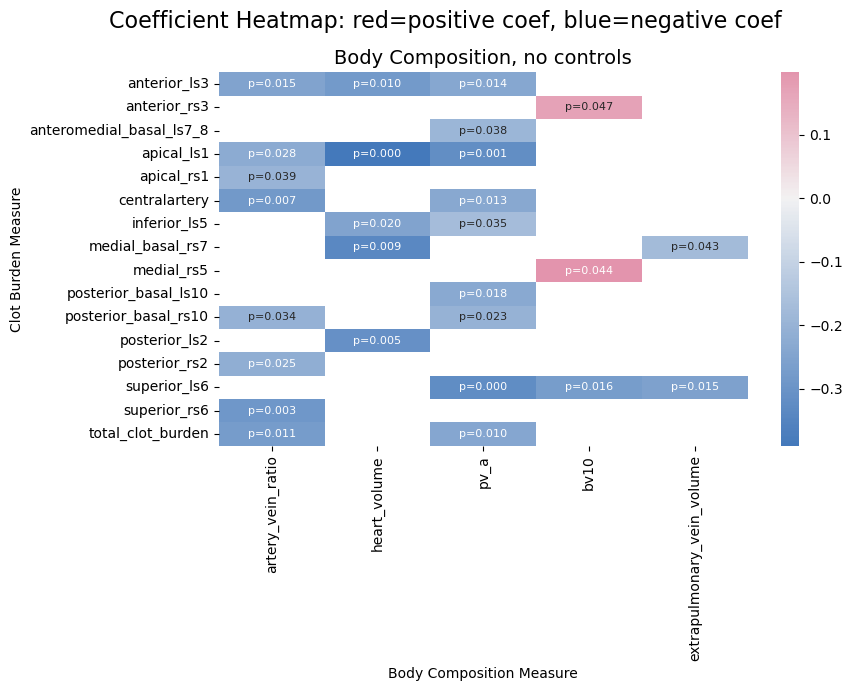

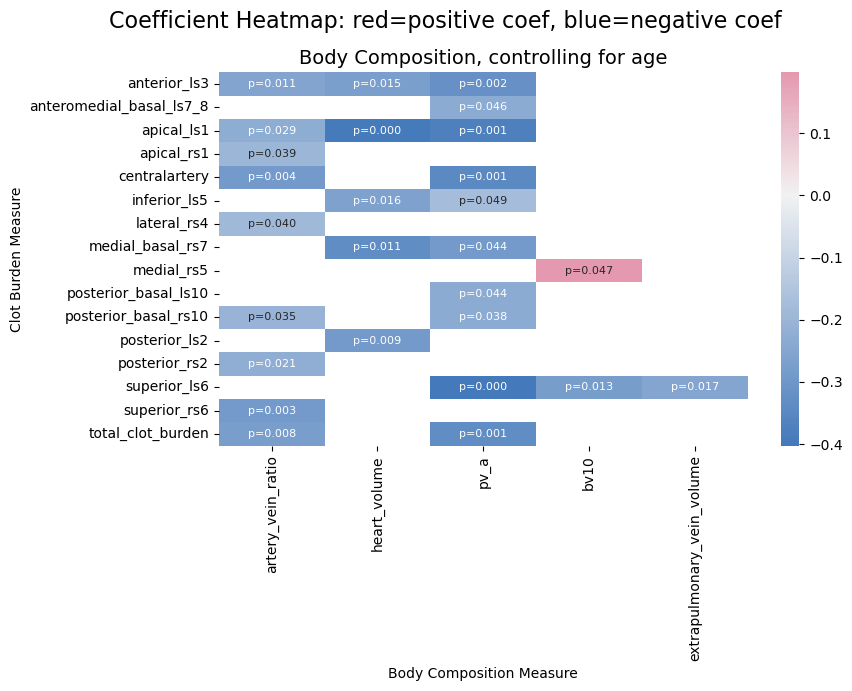

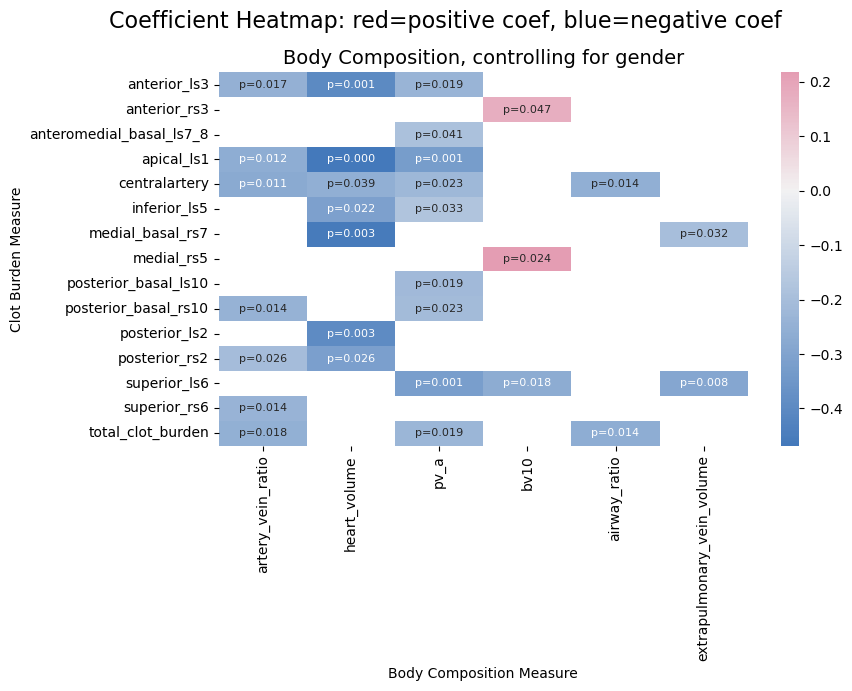

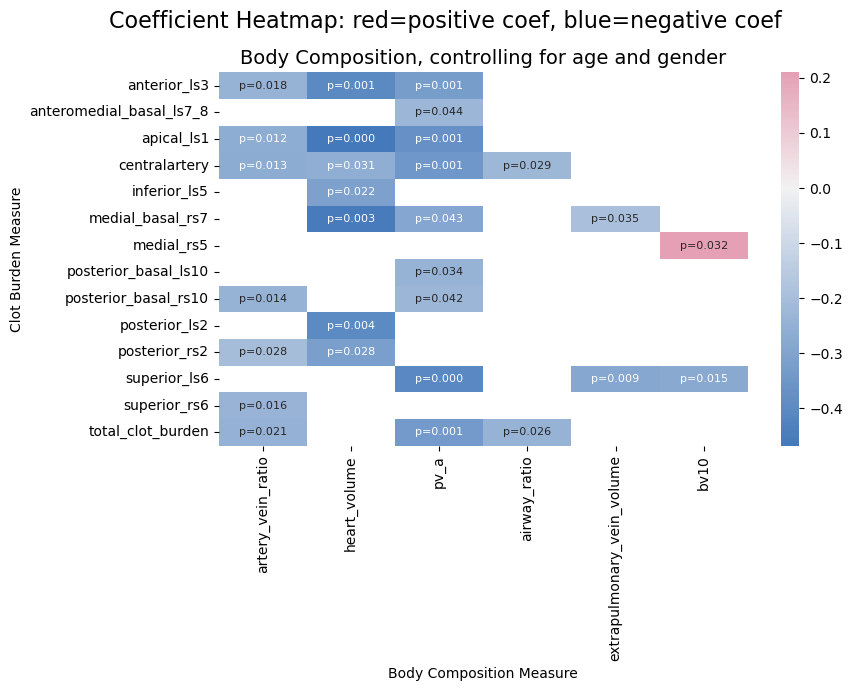

In [18]:
cardio_regression_df = pd.DataFrame()

#########################################
# OLS Body, No Controls                 #
#########################################

ols = ols_regression(
	Xdata=X, Ydata=y, 
	targets=y.columns,
	features=cardio_features,
	controls=None
)
plot_subtitle = 'Body Composition, no controls'
ols_heatmap(ols, '../figures/heatmap_ols_cardio_controls=[None].png', plot_subtitle)
cardio_regression_df = pd.concat([cardio_regression_df, ols], axis=0)

#########################################
# OLS Body, control for age             #
#########################################

ols = ols_regression(
	Xdata=X, Ydata=y, 
	targets=y.columns,
	features=cardio_features,
	controls=['age']
)
plot_subtitle = 'Body Composition, controlling for age'
ols_heatmap(ols, '../figures/heatmap_ols_cardio_controls=[age].png', plot_subtitle)
cardio_regression_df = pd.concat([cardio_regression_df, ols], axis=0)

#########################################
# OLS Body, control for gender          #
#########################################

ols = ols_regression(
	Xdata=X, Ydata=y, 
	targets=y.columns,
	features=cardio_features,
	controls=['gender_cl_Male']
)
plot_subtitle = 'Body Composition, controlling for gender'
ols_heatmap(ols, '../figures/heatmap_ols_cardio_controls=[gender_cl_Male].png', plot_subtitle)
cardio_regression_df = pd.concat([cardio_regression_df, ols], axis=0)

#########################################
# OLS Body, control for age and gender  #
#########################################

ols = ols_regression(
	Xdata=X, Ydata=y, 
	targets=y.columns,
	features=cardio_features,
	controls=['age', 'gender_cl_Male']
)
plot_subtitle = 'Body Composition, controlling for age and gender'
ols_heatmap(ols, '../figures/heatmap_ols_cardio_controls=[age, gender].png', plot_subtitle)
cardio_regression_df = pd.concat([cardio_regression_df, ols], axis=0)


### Export combined univariate regression results

In [19]:
regression_results = pd.concat([body_regressions_df, cardio_regression_df], axis=0)

regression_results = regression_results.reset_index()
regression_results.index = regression_results[['y_var', 'x_var', 'controls']].apply('_'.join, axis=1)
regression_results.index.name = 'Lookup'

regression_results['variable_signif'] = regression_results['variable_pvalue'].apply(reg.add_significance)

regression_results.to_csv('../output/regressions/ols_univariate_all.csv')
regression_results.head()

,y_var,x_var,controls,const_coef,const_pvalue,const_nobs,const_r2_adj,variable_coef,variable_pvalue,variable_nobs,variable_r2_adj,age_coef,age_pvalue,age_nobs,age_r2_adj,gender_cl_Male_coef,gender_cl_Male_pvalue,gender_cl_Male_nobs,gender_cl_Male_r2_adj,variable_signif
Lookup,,,,,,,,,,,,,,,,,,,,
anterior_basal_rs8_bmi_None,anterior_basal_rs8,bmi,None,-7.979728e-17,1.0,95.0,-0.006385,-0.065737,0.560636,95.0,-0.006385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
anterior_basal_rs8_density_bone_None,anterior_basal_rs8,density_bone,None,-7.979728e-17,1.0,95.0,-0.006625,0.063908,0.594205,95.0,-0.006625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
anterior_basal_rs8_density_intermuscular_fat_None,anterior_basal_rs8,density_intermuscular_fat,None,-7.979728e-17,1.0,95.0,0.010915,-0.146416,0.278550,95.0,0.010915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
anterior_basal_rs8_density_muscle_None,anterior_basal_rs8,density_muscle,None,-7.979728e-17,1.0,95.0,-0.008235,-0.049912,0.547973,95.0,-0.008235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
anterior_basal_rs8_density_visceral_fat_None,anterior_basal_rs8,density_visceral_fat,None,-7.979728e-17,1.0,95.0,-0.005270,-0.073647,0.383614,95.0,-0.005270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,


## Multivariable Regressions

### Feature Selection

#### Recursive Feature Selection

In [20]:
rfecv_results = dict()

for target in y.columns:
	ols = LinearRegression(fit_intercept=True)

	rfecv = RFECV(
		estimator=ols,
		step=1,
		scoring='neg_mean_squared_error',
		cv=10
	)

	rfecv.fit(X[cardio_features], y[target])
	rfecv_results[target] = list(rfecv.get_feature_names_out())

rfecv_regressions = pd.DataFrame()
for controls in [None, ['age'], ['gender_cl_Male'], ['age', 'gender_cl_Male']]:
    rfecv_regressions = pd.concat([rfecv_regressions, feature_selection_regressions(
        rfecv_results, 
        selection_method='rfecv',
        controls=controls,
    )], axis=0)
rfecv_regressions.head()

coef  \
feature_selection_method y                 X                 controls                 
rfecv                    total_clot_burden const             None     -1.110223e-16   
                                           airway_ratio      None     -2.919845e-01   
                                           pv_a              None     -2.300874e-01   
                                           artery_vein_ratio None     -3.467826e-01   
                         centralartery     const             None     -1.387779e-17   

                                                                           pval  \
feature_selection_method y                 X                 controls             
rfecv                    total_clot_burden const             None      1.000000   
                                           airway_ratio      None      0.002001   
                                           pv_a              None      0.004068   
                                           artery_vein_ratio None      0.000727   
                         centralartery     const             None      1.000000   

                                                                       nobs  \
feature_selection_method y                 X                 controls         
rfecv                    total_clot_burden const             None      95.0   
                                           airway_ratio      None      95.0   
                                           pv_a              None      95.0   
                                           artery_vein_ratio None      95.0   
                         centralartery     const             None      95.0   

                                                                      signif  
feature_selection_method y                 X                 controls         
rfecv                    total_clot_burden const             None             
                                           airway_ratio      None         **  
                                           pv_a              None         **  
                                           artery_vein_ratio None        ***  
                         centralartery     const             None

#### Sequential Feature Selection (Forward)

In [21]:
sfs_fwd_results = dict()

for target in y.columns:
	ols = LinearRegression(fit_intercept=True)

	sfs_fwd = SequentialFeatureSelector(
		estimator=ols,
		n_features_to_select='auto',
		tol=0.01,
		scoring='neg_mean_squared_error',
		direction='forward',
		cv=10
	)

	sfs_fwd.fit(X[cardio_features], y[target])
	sfs_fwd_results[target] = sfs_fwd.get_feature_names_out()

sfs_fwd_regressions = pd.DataFrame()
for controls in [None, ['age'], ['gender_cl_Male'], ['age', 'gender_cl_Male']]:
    sfs_fwd_regressions = pd.concat([sfs_fwd_regressions, feature_selection_regressions(
        sfs_fwd_results,
        selection_method='sfs_fwd',
        controls=controls
    )], axis=0)
sfs_fwd_regressions.head()

coef  \
feature_selection_method y                 X                 controls                 
sfs_fwd                  total_clot_burden const             None     -1.110223e-16   
                                           airway_ratio      None     -2.919845e-01   
                                           pv_a              None     -2.300874e-01   
                                           artery_vein_ratio None     -3.467826e-01   
                         centralartery     const             None     -1.387779e-17   

                                                                           pval  \
feature_selection_method y                 X                 controls             
sfs_fwd                  total_clot_burden const             None      1.000000   
                                           airway_ratio      None      0.002001   
                                           pv_a              None      0.004068   
                                           artery_vein_ratio None      0.000727   
                         centralartery     const             None      1.000000   

                                                                       nobs  \
feature_selection_method y                 X                 controls         
sfs_fwd                  total_clot_burden const             None      95.0   
                                           airway_ratio      None      95.0   
                                           pv_a              None      95.0   
                                           artery_vein_ratio None      95.0   
                         centralartery     const             None      95.0   

                                                                      signif  
feature_selection_method y                 X                 controls         
sfs_fwd                  total_clot_burden const             None             
                                           airway_ratio      None         **  
                                           pv_a              None         **  
                                           artery_vein_ratio None        ***  
                         centralartery     const             None

#### Sequential Feature Selection (Backward)

In [22]:
sfs_bwd_results = dict()

for target in y.columns:
	ols = LinearRegression(fit_intercept=True)

	sfs_fwd = SequentialFeatureSelector(
		estimator=ols,
		n_features_to_select='auto',
		tol=0.01,
		scoring='neg_mean_squared_error',
		direction='backward',
		cv=10
	)

	sfs_fwd.fit(X[cardio_features], y[target])
	sfs_bwd_results[target] = sfs_fwd.get_feature_names_out()

sfs_bwd_regressions = pd.DataFrame()
for controls in [None, ['age'], ['gender_cl_Male'], ['age', 'gender_cl_Male']]:
    sfs_bwd_regressions = pd.concat([sfs_bwd_regressions, feature_selection_regressions(
        sfs_bwd_results,
        selection_method='sfs_bwd',
        controls=controls
    )], axis=0)
sfs_bwd_regressions.head()

coef  \
feature_selection_method y                 X            controls                 
sfs_bwd                  total_clot_burden const        None     -1.110223e-16   
                                           heart_volume None     -1.585344e-01   
                                           pv_a         None     -1.913565e-01   
                                           airway_ratio None     -2.764856e-01   
                                           ild_volume   None      3.648745e-02   

                                                                      pval  \
feature_selection_method y                 X            controls             
sfs_bwd                  total_clot_burden const        None      1.000000   
                                           heart_volume None      0.240879   
                                           pv_a         None      0.024272   
                                           airway_ratio None      0.004619   
                                           ild_volume   None      0.704634   

                                                                  nobs signif  
feature_selection_method y                 X            controls               
sfs_bwd                  total_clot_burden const        None      95.0         
                                           heart_volume None      95.0         
                                           pv_a         None      95.0      *  
                                           airway_ratio None      95.0     **  
                                           ild_volume   None      95.0

#### Combine feature selection results

In [23]:
feat_selection_cardio = pd.concat([rfecv_regressions, sfs_fwd_regressions, sfs_bwd_regressions])
feat_selection_cardio.head()

coef  \
feature_selection_method y                 X                 controls                 
rfecv                    total_clot_burden const             None     -1.110223e-16   
                                           airway_ratio      None     -2.919845e-01   
                                           pv_a              None     -2.300874e-01   
                                           artery_vein_ratio None     -3.467826e-01   
                         centralartery     const             None     -1.387779e-17   

                                                                           pval  \
feature_selection_method y                 X                 controls             
rfecv                    total_clot_burden const             None      1.000000   
                                           airway_ratio      None      0.002001   
                                           pv_a              None      0.004068   
                                           artery_vein_ratio None      0.000727   
                         centralartery     const             None      1.000000   

                                                                       nobs  \
feature_selection_method y                 X                 controls         
rfecv                    total_clot_burden const             None      95.0   
                                           airway_ratio      None      95.0   
                                           pv_a              None      95.0   
                                           artery_vein_ratio None      95.0   
                         centralartery     const             None      95.0   

                                                                      signif  
feature_selection_method y                 X                 controls         
rfecv                    total_clot_burden const             None             
                                           airway_ratio      None         **  
                                           pv_a              None         **  
                                           artery_vein_ratio None        ***  
                         centralartery     const             None

In [24]:
feat_selection_all = pd.concat([feat_selection_body, feat_selection_cardio], axis=0)
feat_selection_all = feat_selection_all.reset_index()
feat_selection_all.index = feat_selection_all[['feature_selection_method', 'y', 'X', 'controls']].apply('_'.join, axis=1)
feat_selection_all.index.name = 'Lookup'
feat_selection_all.to_csv('../output/regressions/ols_multivariable_all.csv')
feat_selection_all.head()


,feature_selection_method,y,X,controls,coef,pval,nobs,signif
Lookup,,,,,,,,
rfecv_total_clot_burden_const_None,rfecv,total_clot_burden,const,None,-1.110223e-16,1.000000,95.0,
rfecv_total_clot_burden_density_intermuscular_fat_None,rfecv,total_clot_burden,density_intermuscular_fat,None,-1.145899e-01,0.373841,95.0,
rfecv_total_clot_burden_density_visceral_fat_None,rfecv,total_clot_burden,density_visceral_fat,None,-1.750083e-01,0.188997,95.0,
rfecv_total_clot_burden_density_muscle_None,rfecv,total_clot_burden,density_muscle,None,2.554389e-01,0.035744,95.0,*
rfecv_centralartery_const_None,rfecv,centralartery,const,None,-1.387779e-17,1.000000,95.0,
